In [1]:
!pip install -q kaggle

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aminebakhtaoui","key":"25dd85a3fb4dd1e9601544726180bfcd"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sayanf/flickr8k

 99% 1.02G/1.04G [00:03<00:00, 244MB/s]
100% 1.04G/1.04G [00:04<00:00, 276MB/s]


In [5]:
!unzip flickr8k.zip
!mv  Flickr8k_images
!mv Flickr8k_text
!ls

Streaming output truncated to the last 5000 lines.
  inflating: Flickr8k_Dataset/2848571082_26454cb981.jpg  
  inflating: Flickr8k_Dataset/2848895544_6d06210e9d.jpg  
  inflating: Flickr8k_Dataset/2848977044_446a31d86e.jpg  
  inflating: Flickr8k_Dataset/2849194983_2968c72832.jpg  
  inflating: Flickr8k_Dataset/2850719435_221f15e951.jpg  
  inflating: Flickr8k_Dataset/2851198725_37b6027625.jpg  
  inflating: Flickr8k_Dataset/2851304910_b5721199bc.jpg  
  inflating: Flickr8k_Dataset/2851931813_eaf8ed7be3.jpg  
  inflating: Flickr8k_Dataset/2852982055_8112d0964f.jpg  
  inflating: Flickr8k_Dataset/285306009_f6ddabe687.jpg  
  inflating: Flickr8k_Dataset/2853205396_4fbe8d7a73.jpg  
  inflating: Flickr8k_Dataset/2853407781_c9fea8eef4.jpg  
  inflating: Flickr8k_Dataset/2853743795_e90ebc669d.jpg  
  inflating: Flickr8k_Dataset/2853811730_fbb8ab0878.jpg  
  inflating: Flickr8k_Dataset/2854207034_1f00555703.jpg  
  inflating: Flickr8k_Dataset/2854234756_8c0e472f51.jpg  
  inflating: Flickr8k_

In [6]:
BASE_DIR = '/content/'
WORKING_DIR = '/content/'

In [7]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [8]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Flickr8k_Dataset')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

test if all the keys had a feautures

In [9]:
# Assuming your dataset is in the 'Flickr8k_Dataset' directory
dataset_directory = os.path.join(BASE_DIR, 'Flickr8k_Dataset')

# Get the list of image filenames in your dataset
image_filenames = [img_name.split('.')[0] for img_name in os.listdir(dataset_directory)]

# Check if all images have corresponding features
missing_features = set(image_filenames) - set(features.keys())

if not missing_features:
    print("All images have corresponding features.")
else:
    print("The following images are missing features:", missing_features)


All images have corresponding features.


In [10]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [11]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [12]:
with open(os.path.join(BASE_DIR, 'Flickr8k_text/Flickr8k.token.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [13]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by tab(\t)
    tokens = line.split('\t')
    if len(tokens) < 2 or not tokens[1]:
        continue
    image_id, caption = tokens[0], tokens[1]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)


  0%|          | 0/40460 [00:00<?, ?it/s]

In [14]:
len(mapping)

8092

In [15]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption


In [16]:
# before preprocess of text
mapping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [17]:
# preprocess the text
clean(mapping)

In [18]:
# after preprocess of text
mapping['1001773457_577c3a7d70']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [19]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [20]:
len(all_captions)

40459

In [21]:
# The first 10 captions
all_captions[:10]

['startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq']

In [22]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [23]:
vocab_size

8484

In [24]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [25]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
val = image_ids[split:]

In [26]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [27]:
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = [], [], []
    vocab_size = vocab_size

    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]

        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)

    return np.array(X1), np.array(X2), np.array(y)


In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

def data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []

    while True:
        keys = list(mapping.keys())
        np.random.shuffle(keys)  # Shuffle the keys to get different samples in each epoch

        for key in keys:
            if key not in features:
                continue

            photo = features[key][0]
            desc_list = mapping[key]

            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

                    if len(X1) == batch_size:
                        yield ([np.array(X1), np.array(X2)], np.array(y))
                        X1, X2, y = [], [], []


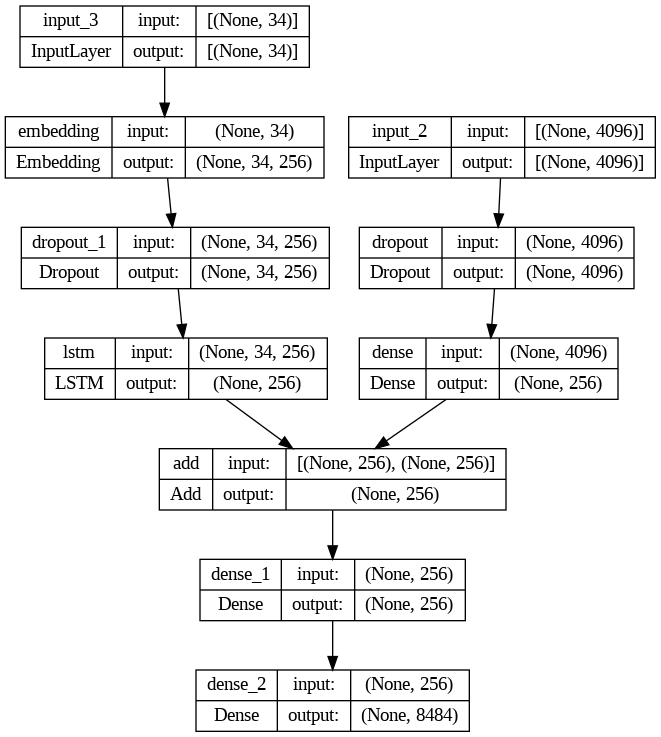

In [29]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [30]:
from tensorflow.keras import backend as K

epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    # Clear GPU memory
    K.clear_session()

227/227 [==============================] - 21s 90ms/step - loss: 4.3439


In [31]:
# save the model
model.save(WORKING_DIR+'f_Caption_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [33]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break

        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [34]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(val):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.486186
BLEU-2: 0.253418


In [35]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Flickr8k_Dataset", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in an orange hat starring at something endseq
startseq man wears an orange hat and glasses endseq
startseq man with gauges and glasses is wearing blitz hat endseq
startseq man with glasses is wearing beer can crocheted hat endseq
startseq the man with pierced ears is wearing glasses and an orange hat endseq
--------------------Predicted--------------------
startseq man in red shirt is standing on the street endseq


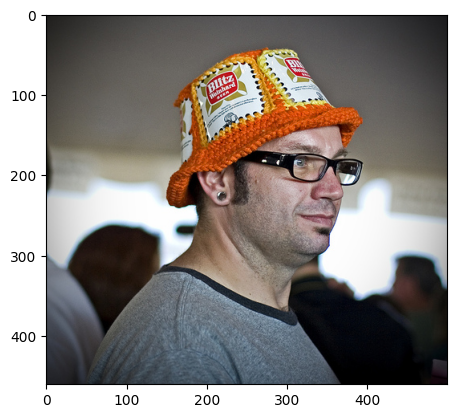

In [38]:
generate_caption("1007129816_e794419615.jpg")

#TEST THE MODEL

In [37]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [ ]:
image_path = '/content/rio_8.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq man in endseq'